In [1]:
import lz4.frame as lz4f
import pickle
import json
import time
import cloudpickle
import gzip
import os
from optparse import OptionParser

import uproot
import numpy as np
from coffea import hist, processor
from coffea.util import load, save
import coffea # Using coffea version 0.6.50

import sys
sys.path.append('../analysis/topEFT')
sys.path.append('../')
import topeft
from topcoffea.modules import samples
from topcoffea.modules.fileReader import GetFiles, GetAllInfoFromFile
outname = 'plotsTopEFT'

nworkers = 10

In [15]:
#pip install 'coffea==0.6.50'

In [2]:
cfgfile=('../cfg/samples.cfg')

In [3]:
#Temporary file for testing
path = "root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root"

In [4]:
def GetOptions(path, sample, options = ""):
    if not path.endswith('/'): path += '/'
    if not sample.endswith(".root"): sample += '.root'
  #doPUweight  = 'PUweight,' if IsVarInTree(path+sample, 'puWeight') else ''
  #doJECunc    = 'JECunc,'   if IsVarInTree(path+sample, 'Jet_pt_jesTotalUp') else ''
  #doIFSR      = 'doIFSR,'   if IsVarInTree(path+sample, 'nPSWeight') and GetValOfVarInTree(path+sample, 'nPSWeight') == 4 else ''
  #useJetPtNom = 'JetPtNom,' if IsVarInTree(path+sample, 'Jet_pt_nom') else ''
  #options += doPUweight + doJECunc + doIFSR + useJetPtNom + options
    if options.endswith(','): options = options[:-1]
    return options

In [5]:
# Rewritten from topcoffea/topcoffea/modules/samples.py
def getdictionary(cfgfile, pretend=1,test=1,verbose=1,path='',sample='',xsec='xsec',year=-1,options='',treeName='Events'):
    samplefiles = {}
    fileopt = {}
    xsecdic = {}
    sampdic = {}
    f = open(cfgfile)
    lines = f.readlines()
    for l in lines:
        l = l.replace(' ', '')
        l = l.replace('\n', '')
        if l.startswith('#'): 
            continue
        if '#' in l: l = l.split('#')[0]
        if l == '': continue
        if l.endswith(':'): l = l[:-1]
        if not ':' in l:
            if l in ['path', 'verbose', 'pretend', 'test', 'options', 'xsec', 'year', 'treeName']: continue
            else: samplefiles[l]=l
        else:
            lst = l.split(':')
            key = lst[0]
            val = lst[1] if lst[1] != '' else lst[0]
            if   key == 'pretend'   : pretend   = 1
            elif key == 'verbose'   : verbose   = int(val) if val.isdigit() else 1
            elif key == 'test'      : dotest    = 1
            elif key == 'path'      :
                path = val
                if len(lst) > 2: 
                    for v in lst[2:]: path += ':'+v
            elif key == 'options'   : options   = val
            elif key == 'xsec'      : xsec      = val
            elif key == 'year'      : year      = int(val)
            elif key == 'treeName'  : treeName  = val
            else:
                fileopt[key] = options
                if len(lst) >= 3: fileopt[key] += lst[2]
                samplefiles[key] = val
    for sname in samplefiles.keys():
        sampdic[sname] = {}
        #sampdic[sname]['files']      = GetFiles(path, samplefiles[sname])
        sampdic[sname]['files']      = [path]
        extraOption = GetOptions(path, sampdic[sname]['files'][0].split('/')[-1])
        sampdic[sname]['options']    = fileopt[sname] + ', ' + extraOption
        sampdic[sname]['xsec']       = xsecdic[sname] if sname in xsecdic.keys() else 1
        sampdic[sname]['year']       = year
        sampdic[sname]['treeName']   = treeName
        nEvents, nGenEvents, nSumOfWeights, isData = GetAllInfoFromFile(sampdic[sname]['files'], sampdic[sname]['treeName'])
        sampdic[sname]['nEvents']       = nEvents
        sampdic[sname]['nGenEvents']    = nGenEvents
        sampdic[sname]['nSumOfWeights'] = nSumOfWeights
        sampdic[sname]['isData']        = isData        
    return(sampdic)

#   Re-assign arguments...
#   aarg = sys.argv
#   if '--pretend' in aarg or '-p' in aarg : pretend     = args.pretend
#   if '--test'    in aarg or '-t' in aarg : dotest      = args.test
#   if args.path       != ''       : path        = args.path
#   if args.options    != ''       : options     = args.options
#   if args.xsec       != 'xsec'   : xsec        = args.xsec
#   if args.year       != -1       : year        = args.year
#   if args.treeName   != 'Events' : treeName    = args.treeName
#   if args.verbose    != 0        : verbose     = int(args.verbose)
#   xsecdic = loadxsecdic(xsec, verbose)


In [6]:
samplesdict = getdictionary(cfgfile,path=path)

In [7]:
flist = {}; xsec = {}; sow = {}; isData = {}
for k in samplesdict.keys():
    flist[k] = samplesdict[k]['files']
    xsec[k]  = samplesdict[k]['xsec']
    sow[k]   = samplesdict[k]['nSumOfWeights']
    isData[k]= samplesdict[k]['isData']

In [8]:
processor_instance = topeft.AnalysisProcessor(samplesdict)

In [9]:
flist

{'DYJetsToLL_MLL50': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root'],
 'DYJetsToLL_M_10to50': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root'],
 'ZZTo2L2Nu': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root'],
 'ZZTo4L': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root'],
 'WZTo3LNU': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root'],
 'WWTo2L2Nu': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root'],
 'tW_noFullHad': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root'],
 'tbarW_noFullHad': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root'],
 'TT': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root'],
 'TTsemilep': ['root:/

In [10]:
#Trying just with one item from filelist, since I don't have Xuan's files, all paths are copies of each other
flist = {'DYJetsToLL_MLL50': ["root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root"]}

In [11]:
flist

{'DYJetsToLL_MLL50': ['root://xcache//store/user/jrgonzal/nanoAODttH/8F38C0F2-E7A7-C846-BBF5-0C040E6BA839.root']}

In [30]:
tstart = time.time()
output = processor.run_uproot_job(flist, 
                                  treename='Events', 
                                  processor_instance=processor_instance, 
                                  executor=processor.futures_executor, 
                                  executor_args={'nano':True}, 
                                  chunksize=500000)

/opt/conda/lib/python3.8/site-packages/coffea/util.py:98: Awkward0Warning: In coffea version 0.7 (target date: January 2021), this will be an error.
(Set awkward1.deprecations_as_errors = True to get a stack trace now.)
TypeError: <class 'coffea.nanoaod.nanoevents.NanoEvents'> relies exclusively on awkward 0.x and will be removed in upcoming versions of coffea!
  warnings.warn(message, Awkward0Warning)
/opt/conda/lib/python3.8/site-packages/coffea/util.py:98: Awkward0Warning: In coffea version 0.7 (target date: January 2021), this will be an error.
(Set awkward1.deprecations_as_errors = True to get a stack trace now.)
TypeError: <class 'coffea.nanoaod.nanoevents.NanoCollection'> relies exclusively on awkward 0.x and will be removed in upcoming versions of coffea!
  warnings.warn(message, Awkward0Warning)


In [31]:
dt = time.time() - tstart

nbins = sum(sum(arr.size for arr in h._sumw.values()) for h in output.values() if isinstance(h, hist.Hist))
nfilled = sum(sum(np.sum(arr > 0) for arr in h._sumw.values()) for h in output.values() if isinstance(h, hist.Hist))
print("Filled %.0f bins, nonzero bins: %1.1f %%" % (nbins, 100*nfilled/nbins,))
print("Processing time: %1.2f s with %i workers (%.2f s cpu overall)" % (dt, nworkers, dt*nworkers, ))

# This is taken from the DM photon analysis...
# Pickle is not very fast or memory efficient, will be replaced by something better soon
#    with lz4f.open("pods/"+options.year+"/"+dataset+".pkl.gz", mode="xb", compression_level=5) as fout:
os.system("mkdir -p histos/")
print('Saving output in %s...'%("histos/" + outname + ".pkl.gz"))
with gzip.open("histos/" + outname + ".pkl.gz", "wb") as fout:
    cloudpickle.dump(output, fout)
print('Done!')

Filled 16146 bins, nonzero bins: 74.3 %
Processing time: 578.43 s with 10 workers (5784.32 s cpu overall)
Saving output in histos/plotsTopEFT.pkl.gz...
Done!


In [41]:
output

{'SumOfEFTweights': <HistEFT (sample,SumOfEFTweights) instance at 0x7f35024b8fd0>,
 'dummy': <Hist (sample,dummy) instance at 0x7f3503676550>,
 'counts': <Hist (sample,channel,cut,counts) instance at 0x7f35036762b0>,
 'invmass': <Hist (sample,channel,cut,invmass) instance at 0x7f3503676880>,
 'njets': <HistEFT (sample,channel,cut,njets) instance at 0x7f3503676490>,
 'nbtags': <HistEFT (sample,channel,cut,nbtags) instance at 0x7f35036762e0>,
 'met': <HistEFT (sample,channel,cut,met) instance at 0x7f35036768e0>,
 'm3l': <HistEFT (sample,channel,cut,m3l) instance at 0x7f3503676820>,
 'wleppt': <HistEFT (sample,channel,cut,wleppt) instance at 0x7f35024b8040>,
 'e0pt': <HistEFT (sample,channel,cut,e0pt) instance at 0x7f35024b8b50>,
 'm0pt': <HistEFT (sample,channel,cut,m0pt) instance at 0x7f35024b82e0>,
 'j0pt': <HistEFT (sample,channel,cut,j0pt) instance at 0x7f35024b8b20>,
 'e0eta': <HistEFT (sample,channel,cut,e0eta) instance at 0x7f35024b8cd0>,
 'm0eta': <HistEFT (sample,channel,cut,m0e

In [12]:
output_path = 'histos/plotsTopEFT.pkl.gz'

In [16]:
# Rewriting from topcoffea/analysis/topEFT/plot.py 

from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
import numpy as np
from coffea import hist, processor 
from coffea.hist import plot
import os, sys

from topcoffea.plotter.plotter import plotter

path = 'histos/plotsTopEFT.pkl.gz'

processDic = {
  'Nonprompt' : 'TTTo2L2Nu,tW_noFullHad, tbarW_noFullHad, WJetsToLNu_MLM, WWTo2L2Nu',
  'DY' : 'DYJetsToLL_M_10to50_MLM, DYJetsToLL_M_50_a',
  'Other': 'WWW,WZG,WWZ,WZZ,ZZZ,tttt,ttWW,ttWZ,ttZH,ttZZ,ttHH,tZq,TTG',
  'WZ' : 'WZTo2L2Q,WZTo3LNu',
  'ZZ' : 'ZZTo2L2Nu,ZZTo2L2Q,ZZTo4L',
  'ttW': 'TTWJetsToLNu',
  'ttZ': 'TTZToLL_M_1to10,TTZToLLNuNu_M_10_a',
  'ttH' : 'ttHnobb,tHq',
  'data' : 'EGamma, SingleMuon, DoubleMuon',
}
bkglist = ['Nonprompt', 'Other', 'DY',  'ttH', 'WZ', 'ZZ', 'ttZ', 'ttW']
allbkg  = ['tt', 'tW', 'WW', 'ttG', 'WW', 'WJets', 'Other', 'DY',  'ttH', 'WZ', 'ZZ', 'ttZ', 'ttW']

colordic ={
  'Other' : '#808080',
  'DY' : '#fbff00',
  'WZ' : '#ffa200',
  'ZZ' : '#8fff00',
  'ttW': '#00a278',
  'ttZ': '#6603ab',
  'VVV' : '#c688b4',
  'tttt' : '#0b23f0',
  'Nonprompt' : '#0b23f0',
  'ttVV' : '#888db5',
  'tHq' : '#5b0003',
  'ttH' : '#f00b0b',
  'tZq' : '#00065b',
  'tt' : '#0b23f0',
  'tW' : '#888db5',
  'ttG' : '#5b0003',
  'WW' : '#f00b0b',
  'WJets' : '#00065b',
}

ch3l = ['eemSSonZ', 'eemSSoffZ', 'mmeSSonZ', 'mmeSSoffZ','eeeSSonZ', 'eeeSSoffZ', 'mmmSSonZ', 'mmmSSoffZ']
ch2lss = ['eeSSonZ', 'eeSSoffZ', 'mmSSonZ', 'mmSSoffZ', 'emSS']
categories = {
 'channel' : ch3l,#['eemSSonZ', 'eemSSoffZ', 'mmeSSonZ', 'mmeSSoffZ','eeeSSonZ', 'eeeSSoffZ', 'mmmSSonZ', 'mmmSSoffZ'],#'eeSSonZ', 'eeSSoffZ', 'mmSSonZ', 'mmSSoffZ', 'emSS'],
 'cut' : ['2jets', '4jets','4j1b', '4j2b'],#['base', '2jets', '4jets', '4j1b', '4j2b'],
 #'Zcat' : ['onZ', 'offZ'],
 #'lepCat' : ['3l'],
}

colors = [colordic[k] for k in bkglist]


def Draw(var, categories, label=''):
    plt = plotter(path, prDic=processDic, bkgList=bkglist)
    plt.plotData = True
    plt.SetColors(colors)
    plt.SetCategories(categories)
    plt.SetRegion(label)
    #plt.Stack(var, xtit='', ytit='')
    #plt.PrintYields('counts')

Draw('met', categories, '3 leptons')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7fbb500a0970>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7fbb507d92e0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7fbb505bfee0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7fbb507e0e50>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeW

<AxesSubplot:xlabel='sow', ylabel='SumOfWeights'>

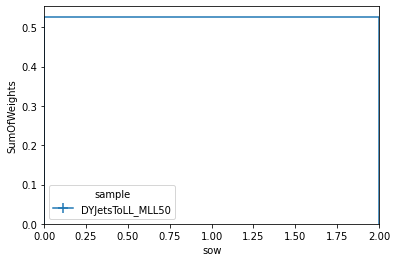

In [40]:
coffea.hist.plot1d(output['SumOfEFTweights'])

ValueError: Plotting multiple histograms with different binning is not supported

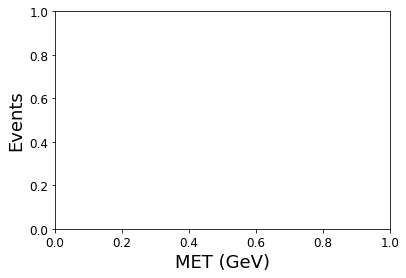

In [130]:
coffea.hist.plot1d(h, overlay="process")

In [132]:
h.fields

['process', 'met']

In [59]:
output['counts'].fields

['sample', 'channel', 'cut', 'counts']

In [64]:
output[''invmass''].fields

SyntaxError: invalid syntax (<ipython-input-64-b1688e721c42>, line 1)

In [75]:
coffea.hist.plotgrid(output['invmass'][0])

IndexError: Cannot understand slice 0 on axis <Cat (name=sample) instance at 0x7f35bc173820>

In [15]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
import numpy as np
from coffea import hist, processor 
from coffea.hist import plot
import os, sys

from topcoffea.plotter.plotter import plotter

path = 'histos/plotsTopEFT.pkl.gz'

processDic = {
  'Nonprompt' : 'TTTo2L2Nu,tW_noFullHad, tbarW_noFullHad, WJetsToLNu_MLM, WWTo2L2Nu',
  'DY' : 'DYJetsToLL_M_10to50_MLM, DYJetsToLL_M_50_a',
  'Other': 'WWW,WZG,WWZ,WZZ,ZZZ,tttt,ttWW,ttWZ,ttZH,ttZZ,ttHH,tZq,TTG',
  'WZ' : 'WZTo2L2Q,WZTo3LNu',
  'ZZ' : 'ZZTo2L2Nu,ZZTo2L2Q,ZZTo4L',
  'ttW': 'TTWJetsToLNu',
  'ttZ': 'TTZToLL_M_1to10,TTZToLLNuNu_M_10_a',
  'ttH' : 'ttHnobb,tHq',
  'data' : 'EGamma, SingleMuon, DoubleMuon',
}
bkglist = ['Nonprompt', 'Other', 'DY',  'ttH', 'WZ', 'ZZ', 'ttZ', 'ttW']
allbkg  = ['tt', 'tW', 'WW', 'ttG', 'WW', 'WJets', 'Other', 'DY',  'ttH', 'WZ', 'ZZ', 'ttZ', 'ttW']

colordic ={
  'Other' : '#808080',
  'DY' : '#fbff00',
  'WZ' : '#ffa200',
  'ZZ' : '#8fff00',
  'ttW': '#00a278',
  'ttZ': '#6603ab',
  'VVV' : '#c688b4',
  'tttt' : '#0b23f0',
  'Nonprompt' : '#0b23f0',
  'ttVV' : '#888db5',
  'tHq' : '#5b0003',
  'ttH' : '#f00b0b',
  'tZq' : '#00065b',
  'tt' : '#0b23f0',
  'tW' : '#888db5',
  'ttG' : '#5b0003',
  'WW' : '#f00b0b',
  'WJets' : '#00065b',
}

ch3l = ['eemSSonZ', 'eemSSoffZ', 'mmeSSonZ', 'mmeSSoffZ','eeeSSonZ', 'eeeSSoffZ', 'mmmSSonZ', 'mmmSSoffZ']
ch2lss = ['eeSSonZ', 'eeSSoffZ', 'mmSSonZ', 'mmSSoffZ', 'emSS']
categories = {
 'channel' : ch3l,#['eemSSonZ', 'eemSSoffZ', 'mmeSSonZ', 'mmeSSoffZ','eeeSSonZ', 'eeeSSoffZ', 'mmmSSonZ', 'mmmSSoffZ'],#'eeSSonZ', 'eeSSoffZ', 'mmSSonZ', 'mmSSoffZ', 'emSS'],
 'cut' : ['2jets', '4jets','4j1b', '4j2b'],#['base', '2jets', '4jets', '4j1b', '4j2b'],
 #'Zcat' : ['onZ', 'offZ'],
 #'lepCat' : ['3l'],
}

colors = [colordic[k] for k in bkglist]


def Draw(var, categories, label=''):
    plt = plotter(path, prDic=processDic, bkgList=bkglist)
    plt.plotData = True
    plt.SetColors(colors)
    plt.SetCategories(categories)
    plt.SetRegion(label)
   # plt.Stack(var, xtit='', ytit='')
   # plt.PrintYields('counts')

Draw('met', categories, '3 leptons')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7fbb38f4f220>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7fbb50624700>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7fbb5062b850>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7fbb50091430>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeW

In [77]:
plt = plotter(path, prDic=processDic, bkgList=bkglist)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7f358d19ffd0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7f359d298df0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7f359d2cd940>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7f359d321100>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeW

In [ ]:

def Draw(var, categories, label=''):
    plt = plotter(path, prDic=processDic, bkgList=bkglist)
    plt.plotData = True
    plt.SetColors(colors)
    plt.SetCategories(categories)
    plt.SetRegion(label)
    plt.Stack(var, xtit='', ytit='')
    plt.PrintYields('counts')

Draw('met', categories, '3 leptons')

In [79]:
plt.SetColors(colors)

In [80]:
plt.SetCategories(categories)

In [82]:
label =''
plt.SetRegion(label)

ValueError: Plotting multiple histograms with different binning is not supported

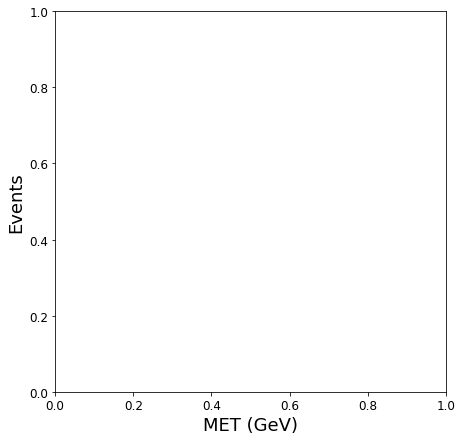

In [83]:
var='met'
plt.Stack(var, xtit='', ytit='')

# Plotting multiple histograms with different binning is not supported

In [134]:
h.sum('met', 'process').values(sumw2=False)

NameError: name 'overflow_behavior' is not defined

In [116]:
#part that works
plt = plotter(path, prDic=processDic, bkgList=bkglist)
plt.plotData = True
plt.SetColors(colors)
plt.SetCategories(categories)
plt.SetRegion(label)
plt.Stack(var, xtit='', ytit='')
#plt.PrintYields('counts')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7f359d2b9e20>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7f358d0ee970>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7f3503e0a3a0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:348: RuntimeWarning: Not all requested indices present in <Cat (name=sample) instance at 0x7f359d2859d0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeW

In [117]:
plt.region

''

In [85]:
plt.PrintYields('counts')

 \\ 

\hline



IndexError: list index out of range

In [135]:
h = plt.GetHistogram(var, plt.bkglist)
plt.lumi=59.7

In [136]:
h.scale(1000.*plt.lumi)

In [137]:
h

<HistEFT (process,met) instance at 0x7f359d3258b0>

ValueError: Plotting multiple histograms with different binning is not supported

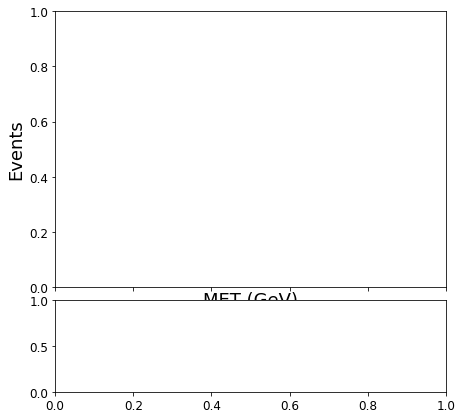

In [138]:
import matplotlib.pyplot as mplt


fig, (ax, rax) = mplt.subplots(2, 1, figsize=(7,7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)
hist.plot1d(h, overlay="process", ax=ax, clear=False, stack=True)


In [127]:
h.fields

['process', 'met']

In [128]:
h

<HistEFT (process,met) instance at 0x7f3503e0a7c0>

In [112]:
y = h[bkglist[3]].integrate("process").values(overflow='all')

{}

In [ ]:

h = self.GetHistogram(var, self.bkglist)
    h.scale(1000.*self.lumi)
    for bkg in self.bkglist:
        if bkg!='DY':
            continue
      y = h[bkg].integrate("process").values(overflow='all')
      y = y[list(y.keys())[0]].sum()
      sumy += y
      dicyields[bkg] = y
    if self.doData(var):
      hData = self.GetHistogram(var, self.dataName)
      ydata = hData.values(overflow='all')
      ndata = ydata[list(ydata.keys())[0]].sum()
      dicyields['data'] = ndata
    return dicyields

In [88]:
bkglist

['Nonprompt', 'Other', 'DY', 'ttH', 'WZ', 'ZZ', 'ttZ', 'ttW']

In [95]:
h['met']

<HistEFT (process,met) instance at 0x7f359d2d5880>